#### Load packages

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt

import gtra

from pathlib import Path

DATA_PATH = Path("/data3/projects/2025_GTRA/data/1_MND")

#### Load data

In [2]:
# Load mouse neuron development
adata = sc.read_h5ad(DATA_PATH / "CCTSD_preproc.h5ad")
adata = adata[:,adata.var.highly_variable].copy()

### Upload time-series scRNA-seq data

In [3]:
gtra_obj = gtra.GTraObject()
gtra_obj.params.cell_type_label = "cell_type2"
gtra_obj.params.output_dir = "./"
gtra_obj.params.output_name = "Mouse"

# Upload time-series scRNA_seq data
for time in sorted(adata.obs["timepoints"].unique()):
    dat = adata[adata.obs["timepoints"]==time]
    cnt_dat = dat.to_df(layer="counts")
    meta = dat.obs[[gtra_obj.params.cell_type_label]]
    gtra_obj.upload_time_scRNA(cnt_dat, meta)

gtra_obj.select_genes()

### Run GTra

#### Step 1: Identifying cell type-specific gene clusters

In [4]:
gtra_obj.find_gclusters(N=20)

Step 1: Identifying cell type-specific gene clusters...


In [5]:
# gtra_obj.params.answer_path_type = "MND"
# gtra_obj.params.answer_path_dir = DATA_PATH / "cctsd_answer.csv"


#### Step 2: Linking gene clusters across time points

In [5]:
gtra_obj.construct_trajectories()

Step 2: Constructing cell-state trajectories..: 100%|=================| 3/3 [00:13<00:00,  4.42s/it]


#### Step 3: Detecting gene expression patterns along trajecotries

In [6]:
gtra_obj.pattern_clustering()

Step 3: Detecting time-series pattern clustering...: 100%|==========| 23/23 [00:04<00:00,  4.92it/s]


### Visualization

##### Edge statistics

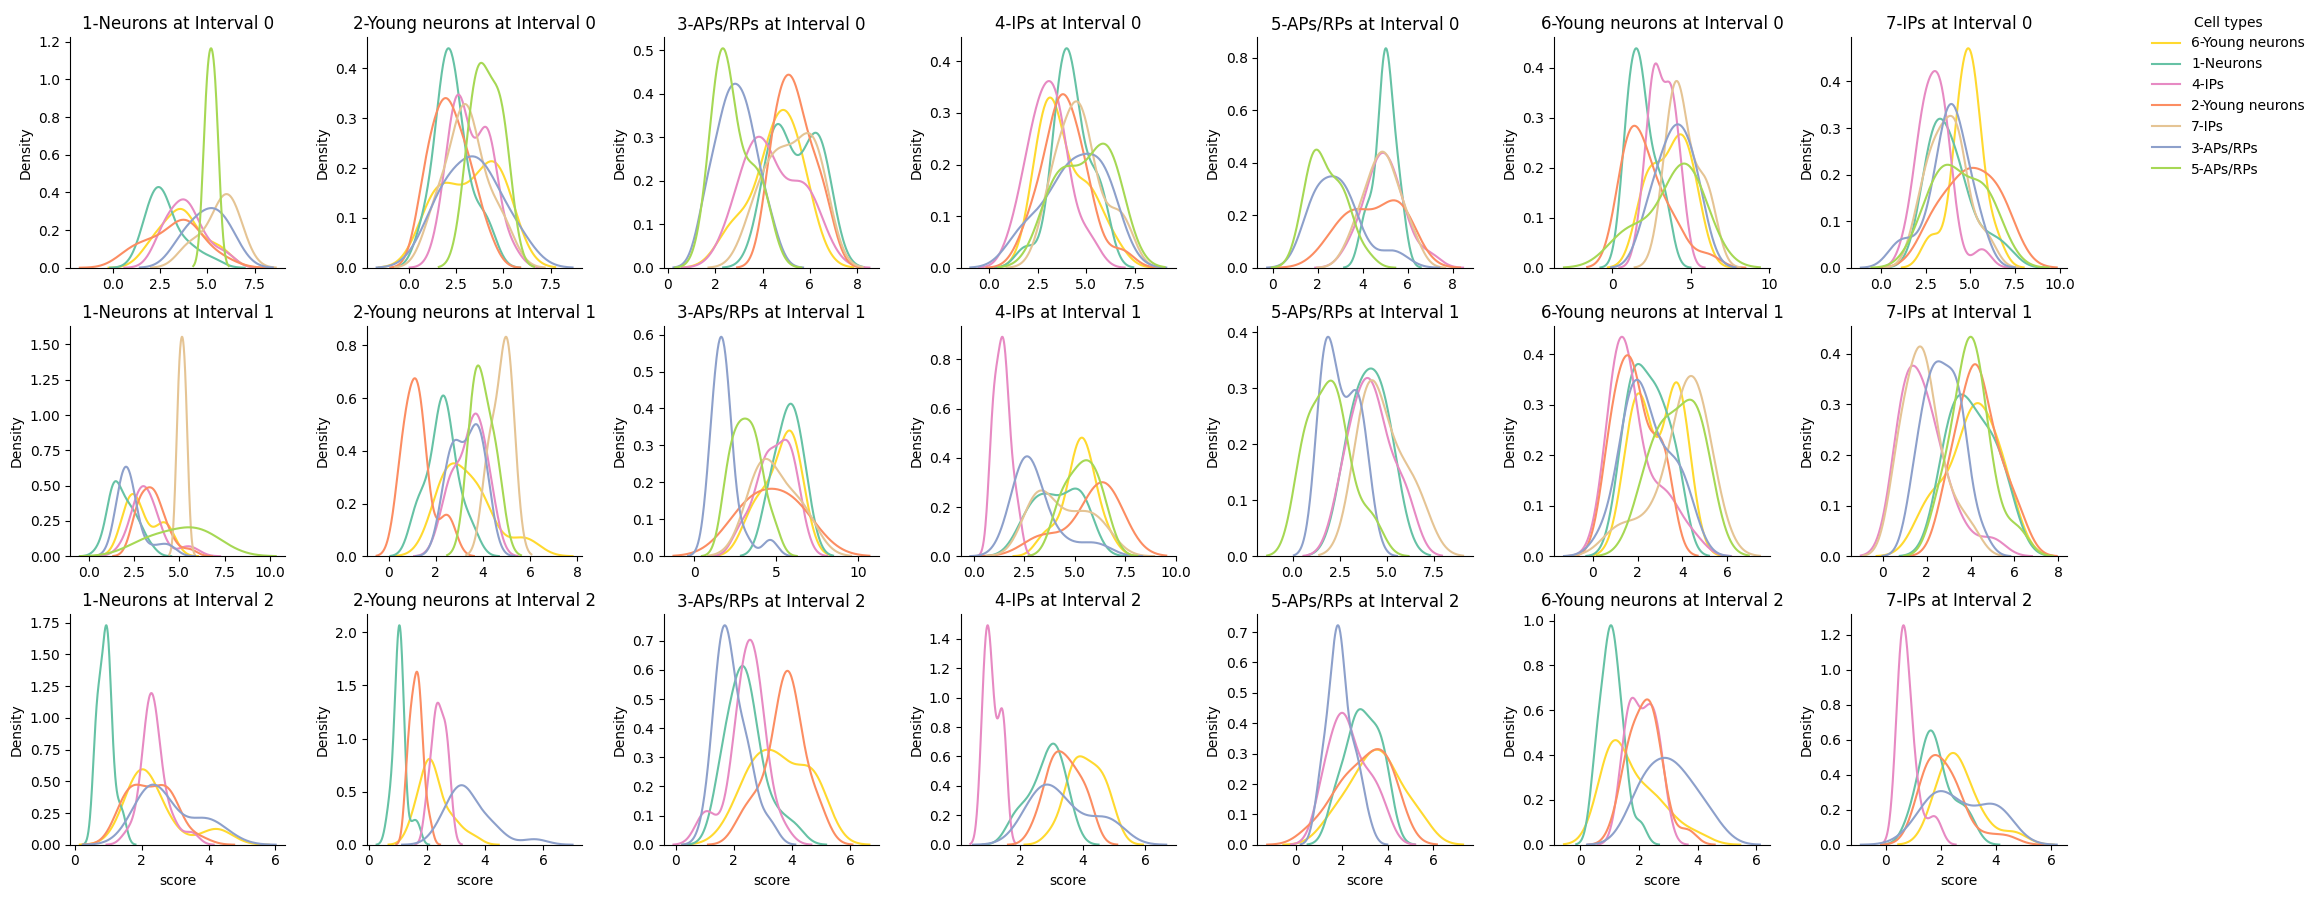

In [7]:
gtra_obj.plot_edge_statistic()

##### Cell state transition graph

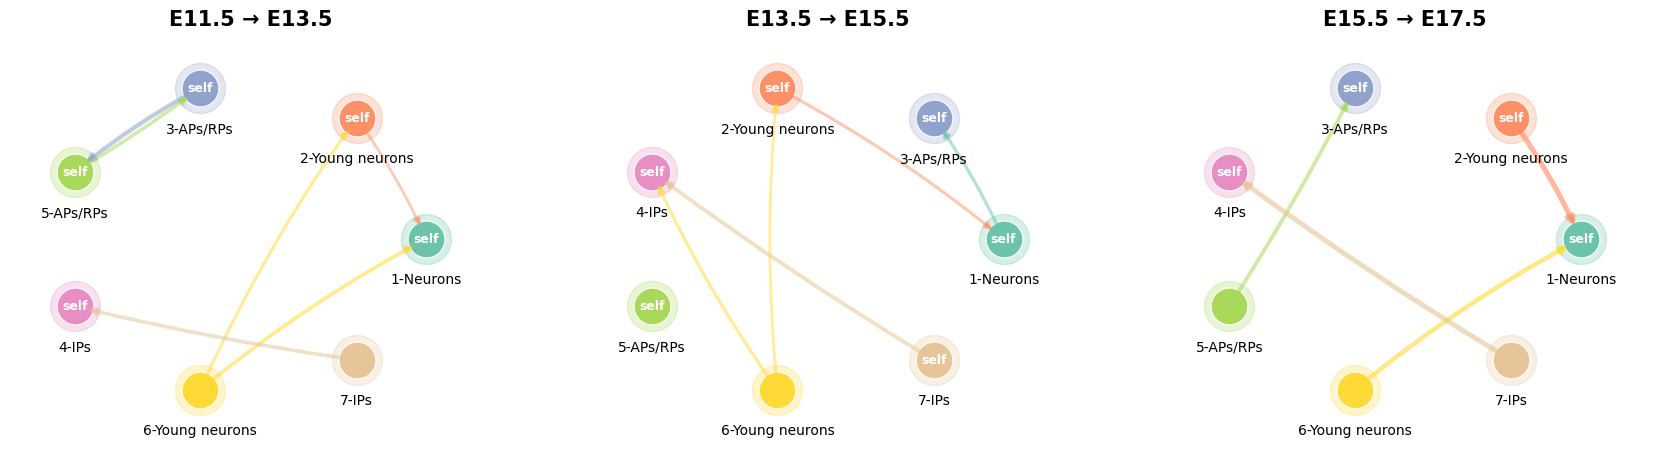

In [8]:
gtra_obj.params.time_point_label = ["E11.5", "E13.5", "E15.5", "E17.5"]
gtra_obj.plot_cell_state_graph()

##### Gene-cluster transition matrix across time points

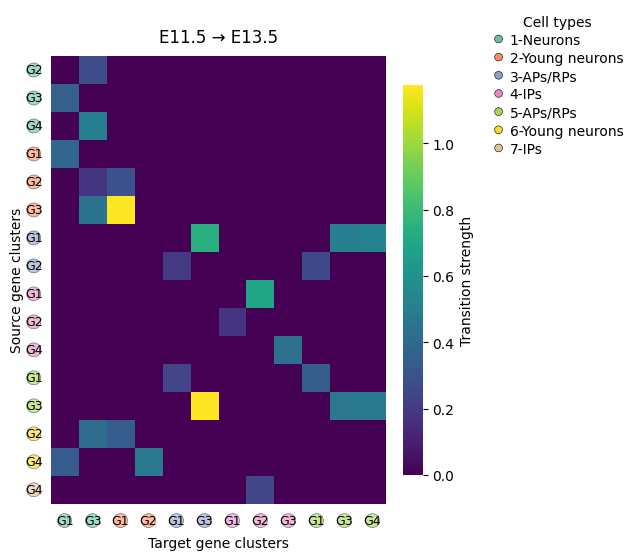

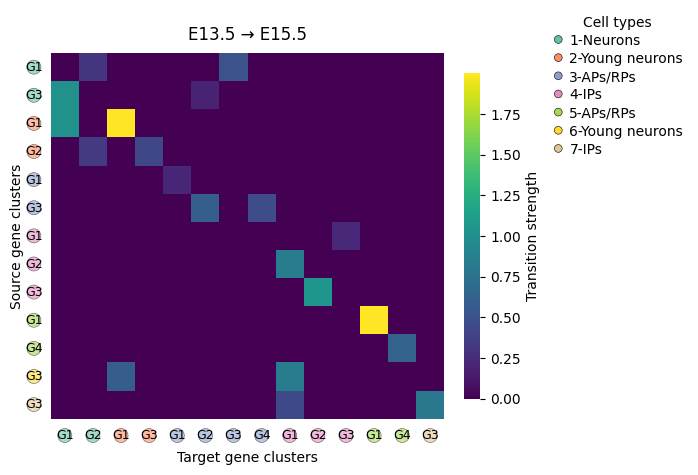

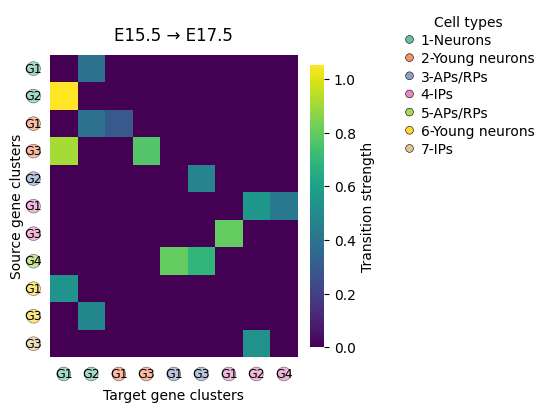

In [9]:
gtra_obj.plot_gg_matrix()

#### Gene expression patterns [Modules] 

Plotting time-series gene expression patterns...


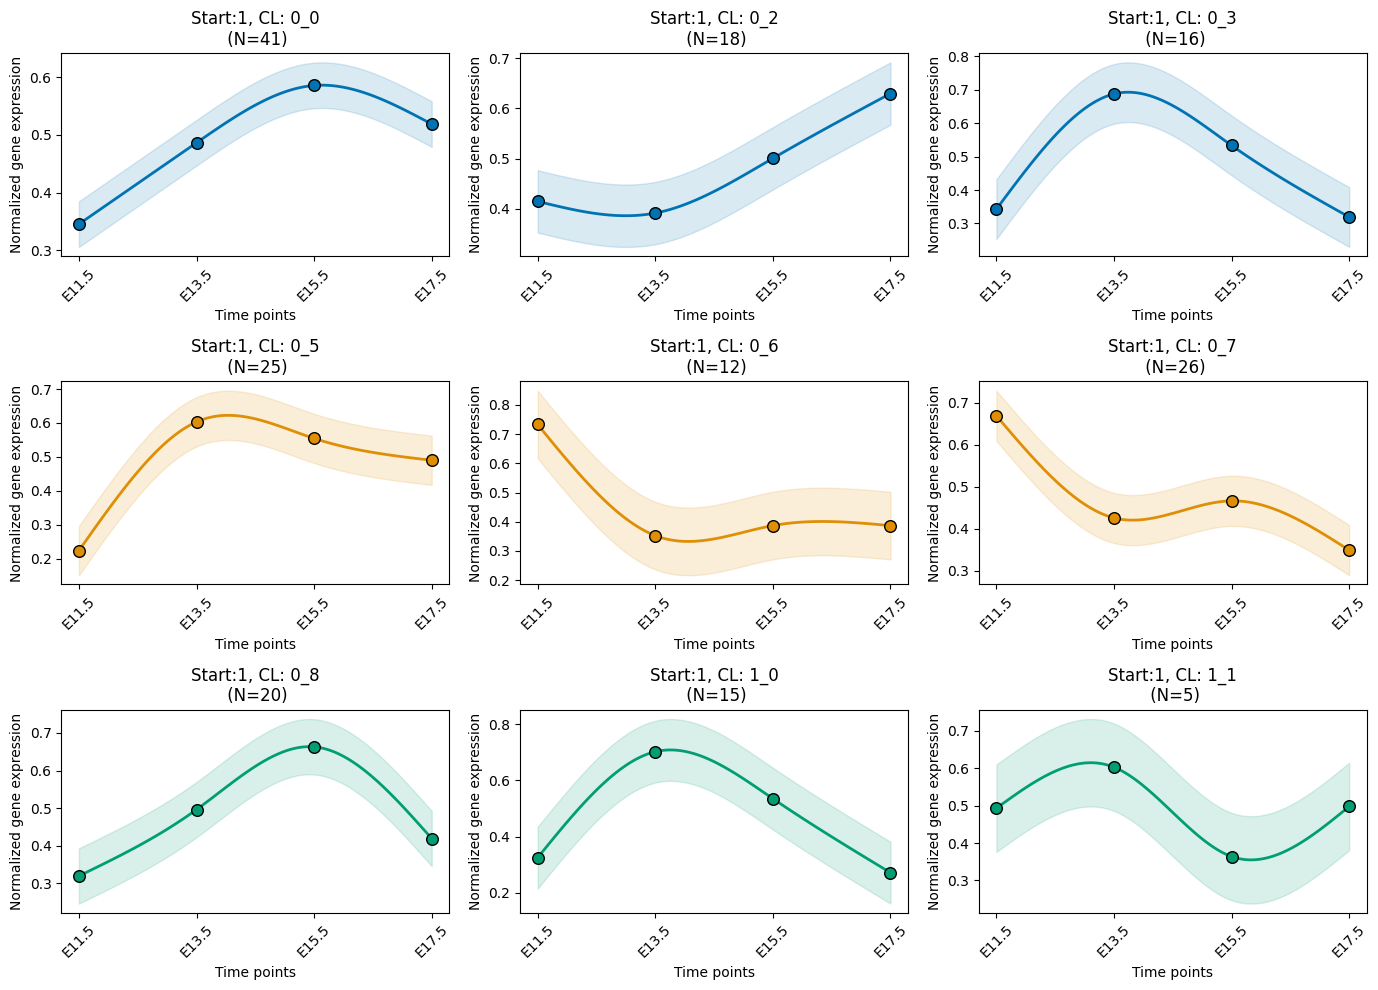

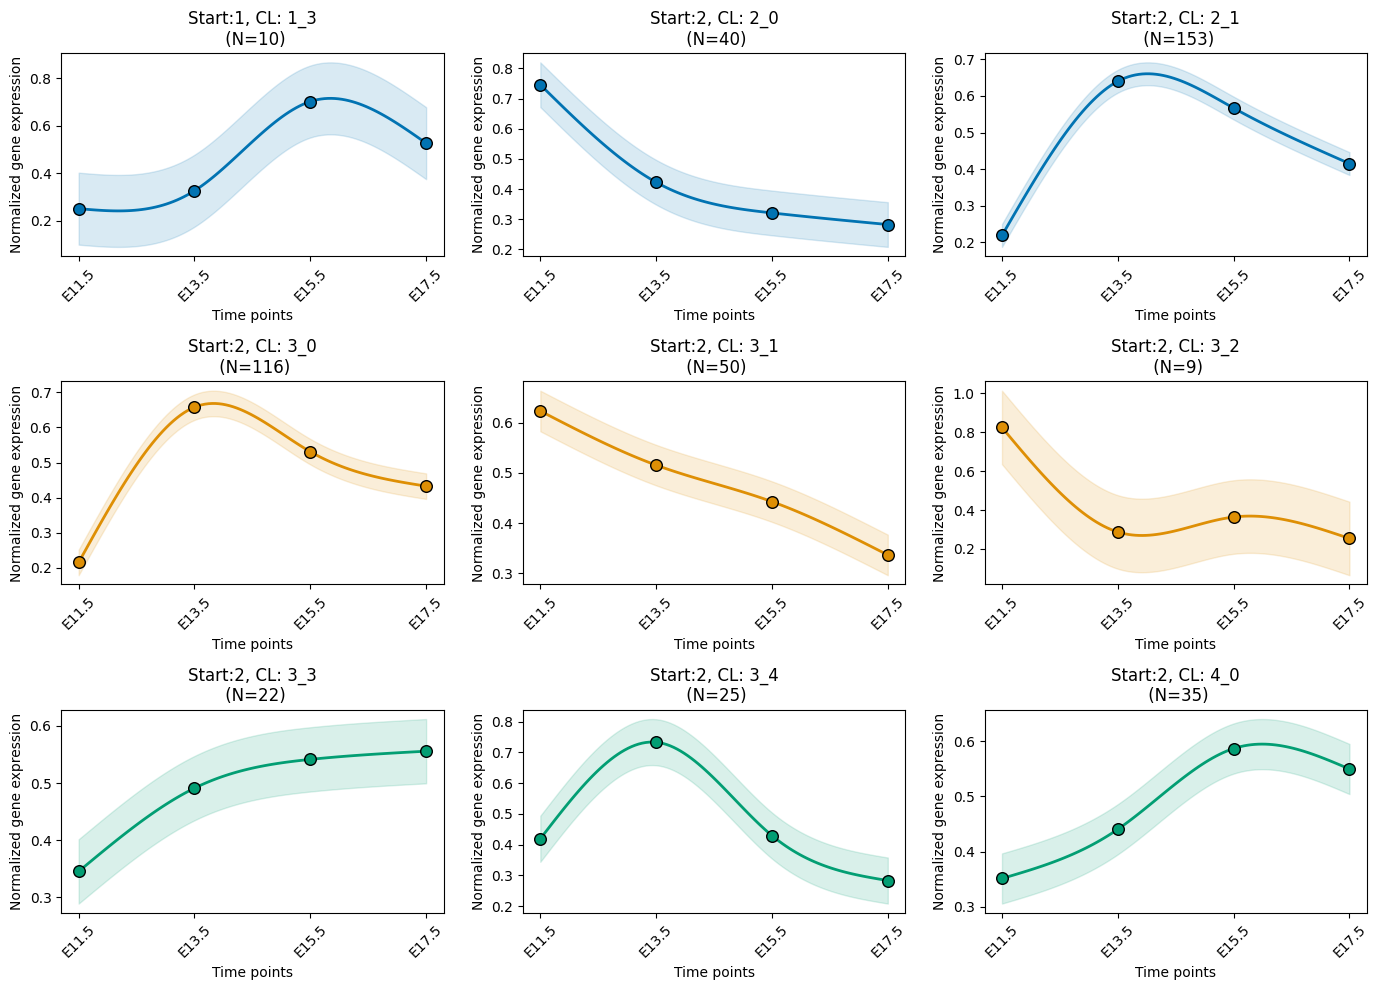

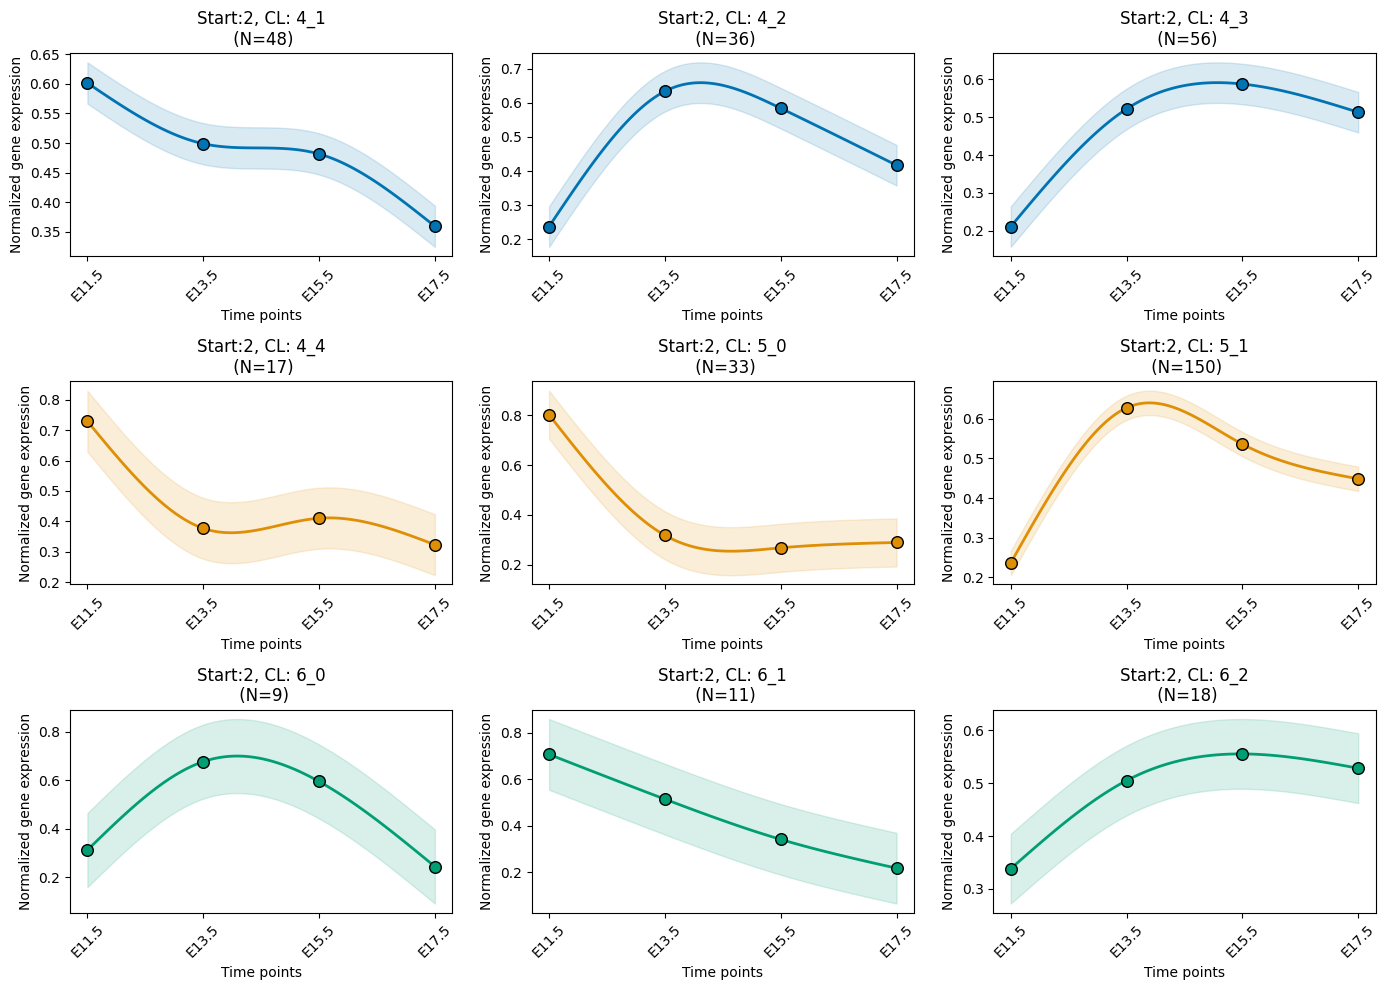

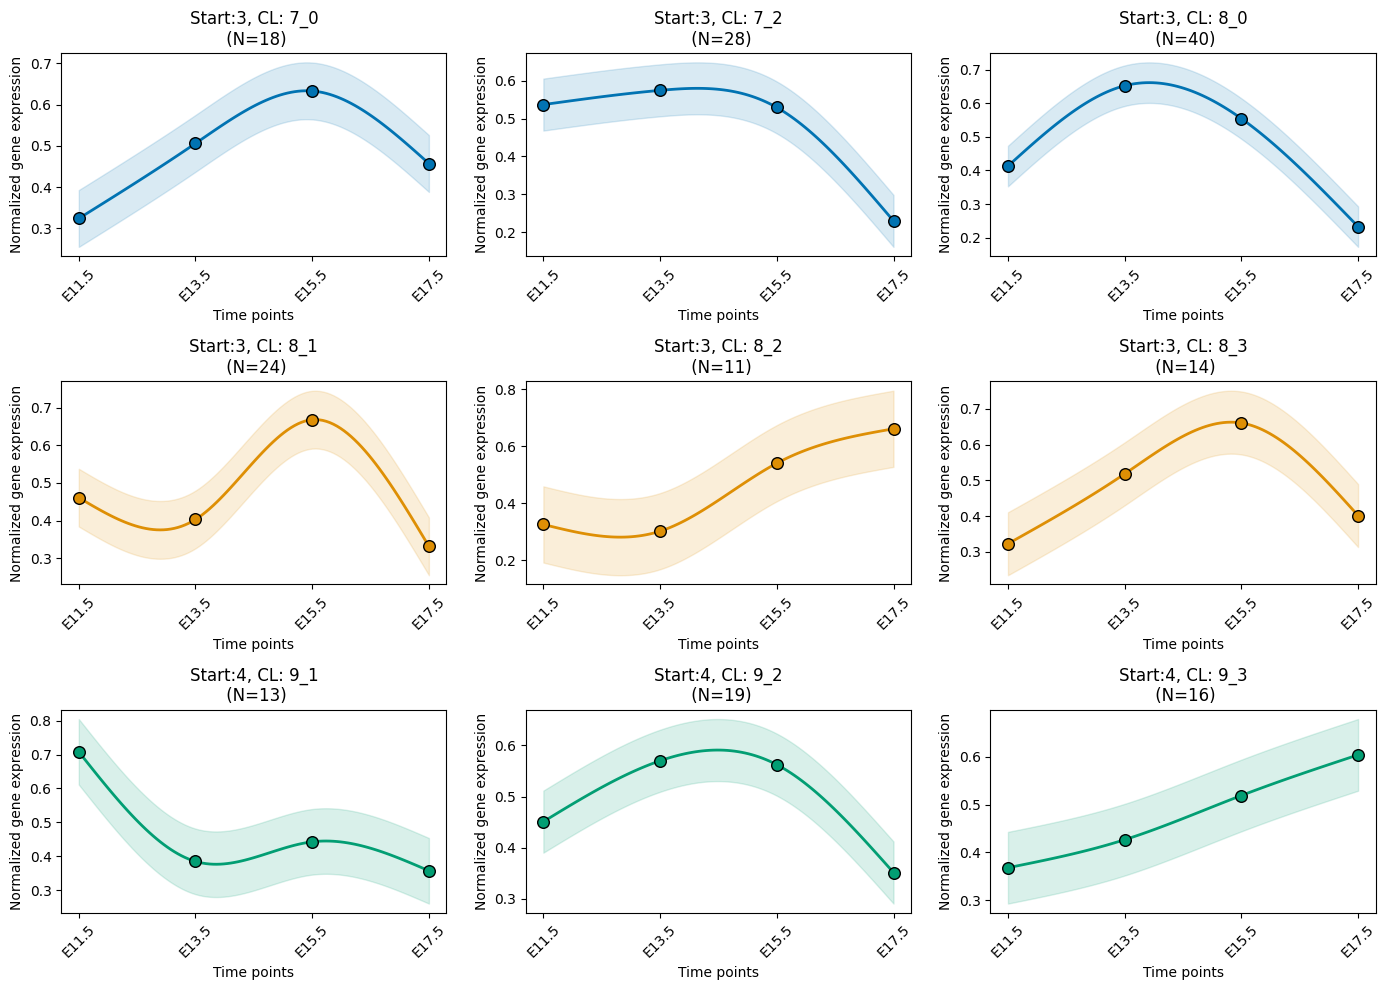

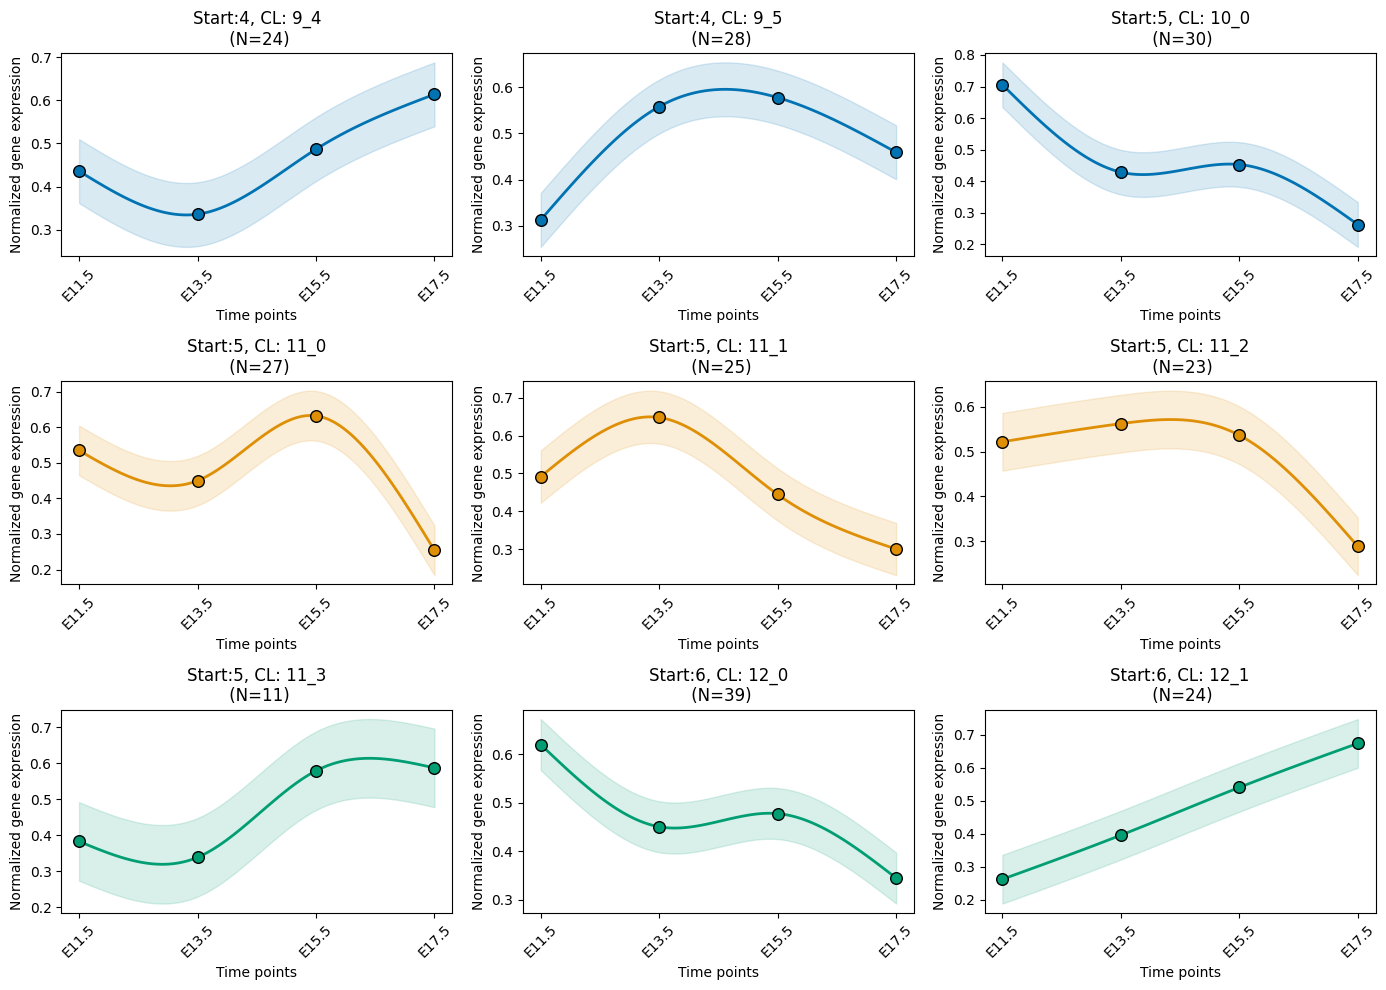

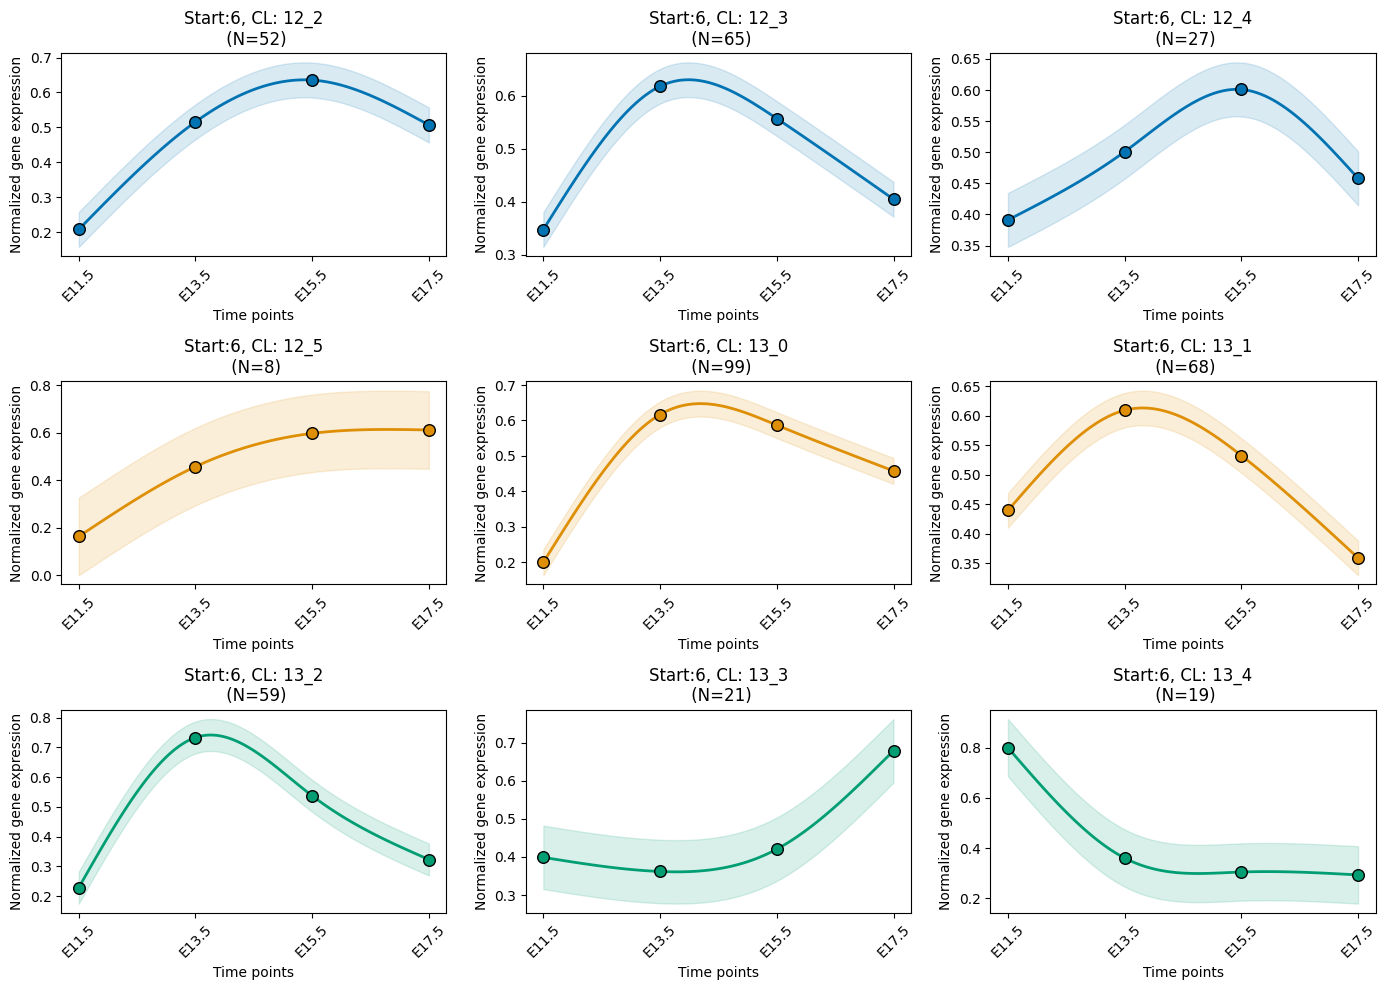

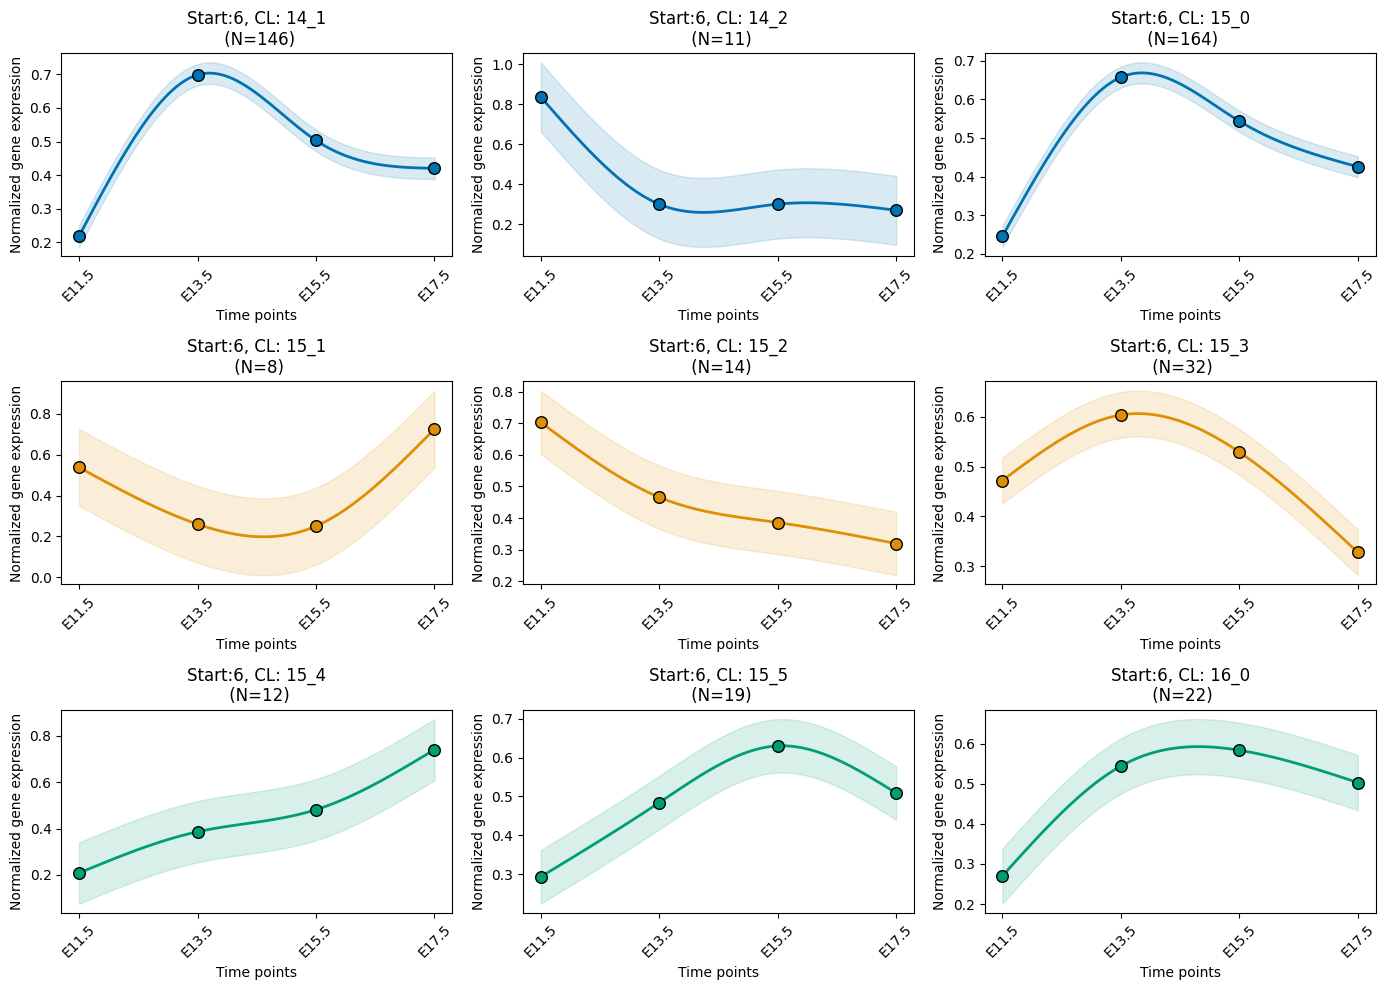

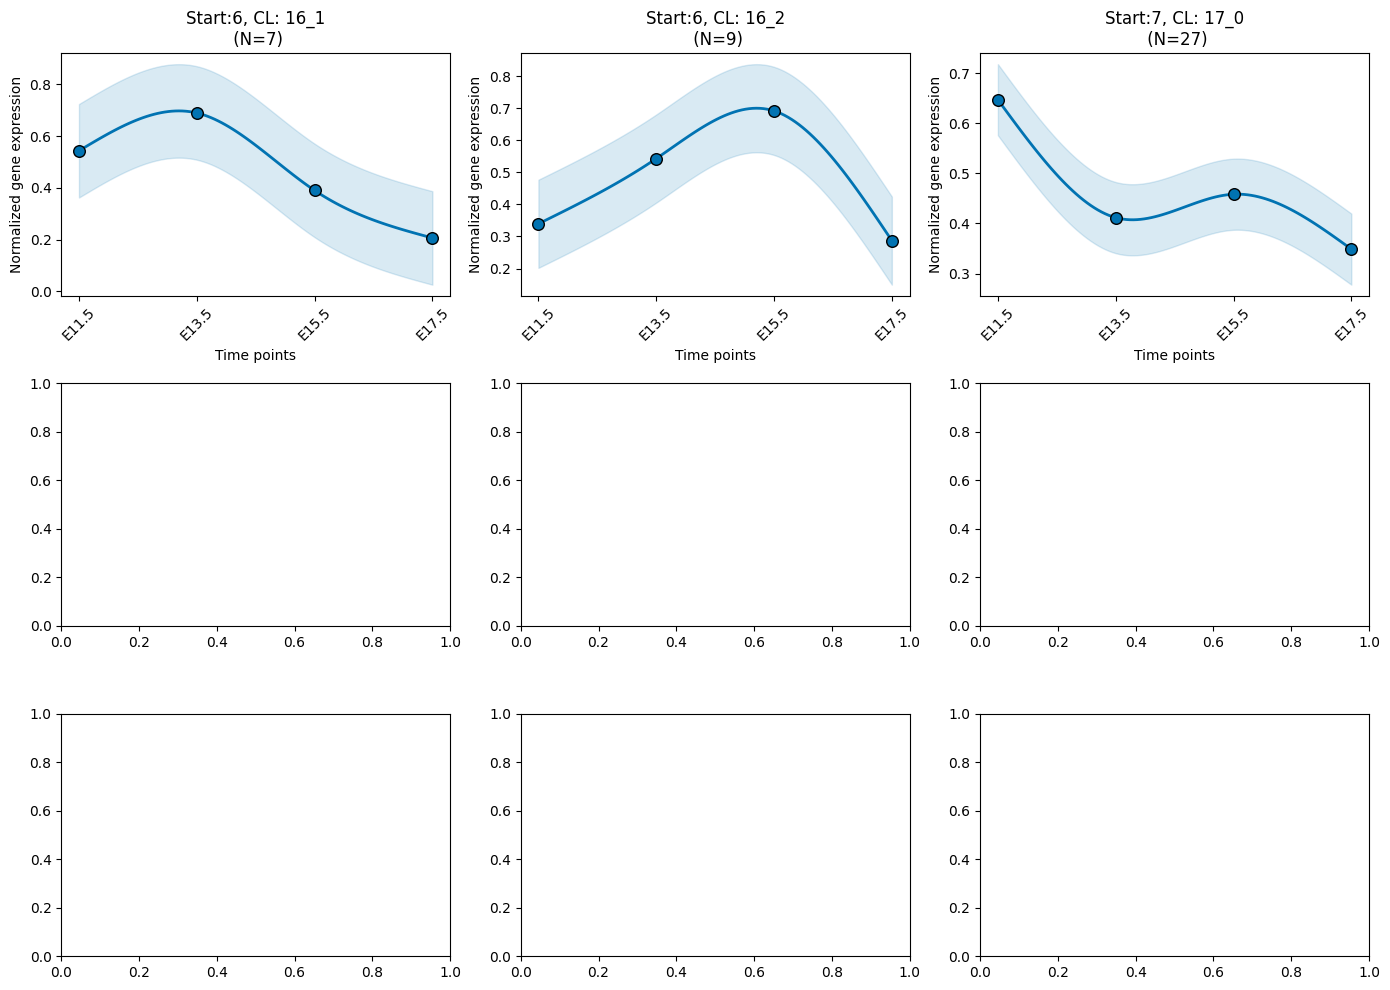

In [10]:
gtra_obj.plot_patterns()

#### Plot trajectory

In [11]:
gtra_obj.plot_trajectory()

In [12]:
gtra_obj.module_evaluation()

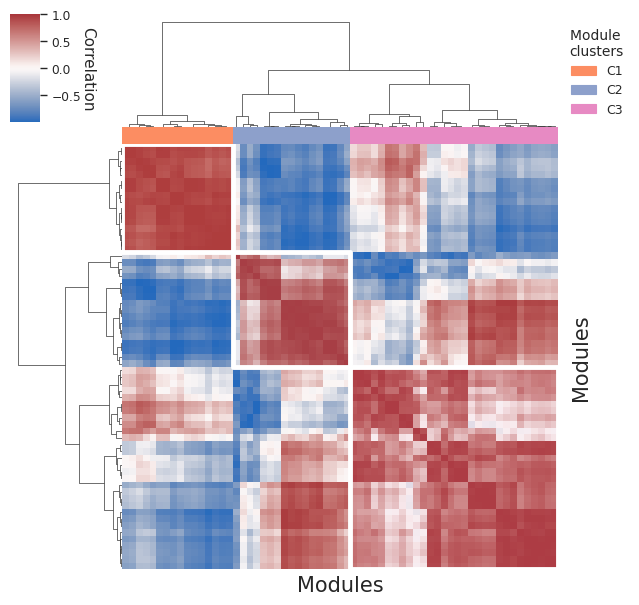

In [15]:
gtra_obj.plot_module_cluster()

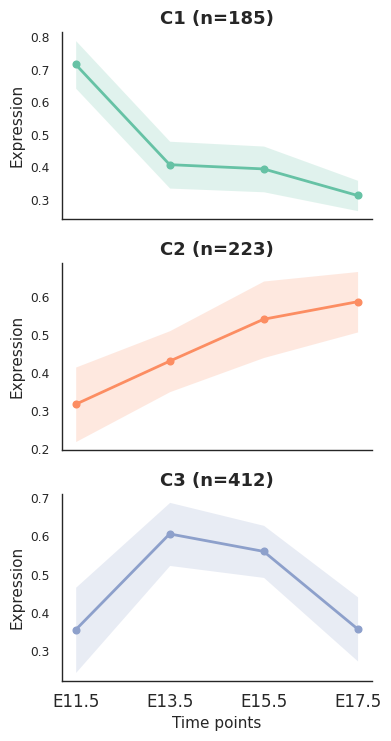

In [16]:
gtra_obj.plot_rep_patterns()

#### Enrichment analysis for module cluster

In [21]:
pt_df = gtra_obj.module_df.copy()
res_df = gtra_obj.sig_patterns.copy()

cgenes_dict = dict()

for c, d in pt_df.groupby("cluster"):
    tmp = []
    for pt in d["Pattern_ID"].values:
        gv = res_df[res_df["Pattern_ID"] == pt]["Genes"].values[0]
        gs = gv.split(';')
        tmp.extend(gs)
    cgenes_dict[c]=set(tmp)

In [27]:
import gseapy as gp

names = gp.get_library_name(organism="Mouse")
enr_c1 = gp.enrichr(gene_list=list(cgenes_dict[1]),
           gene_sets=["GO_Biological_Process_2025"],
           organism="Mouse",
           outdir=None)
enr_c2 = gp.enrichr(gene_list=list(cgenes_dict[2]),
           gene_sets=["GO_Biological_Process_2025"],
           organism="Mouse",
           outdir=None)
enr_c3 = gp.enrichr(gene_list=list(cgenes_dict[3]),
           gene_sets=["GO_Biological_Process_2025"],
           organism="Mouse",
           outdir=None)


In [28]:
enr_c1.res2d["Cluster"] = "C1"
enr_c2.res2d["Cluster"] = "C2"
enr_c3.res2d["Cluster"] = "C3"
enr_res = pd.concat([enr_c1.res2d, enr_c2.res2d,enr_c3.res2d])

def shorten_term(term):
    replacements = {
        "Regulation": "Reg.",
        "Positive": "Pos.",
        "Negative": "Neg.",
        "Transcription": "Tx",
        "DNA-templated": "DNA-tmp",
        "RNA Polymerase II": "Pol II",
        "Process": "Proc.",
        "Development": "Dev."
    }
    for long, short in replacements.items():
        term = term.replace(long, short)
    return term

enr_res['Short_term'] = enr_res['Term'].apply(shorten_term)

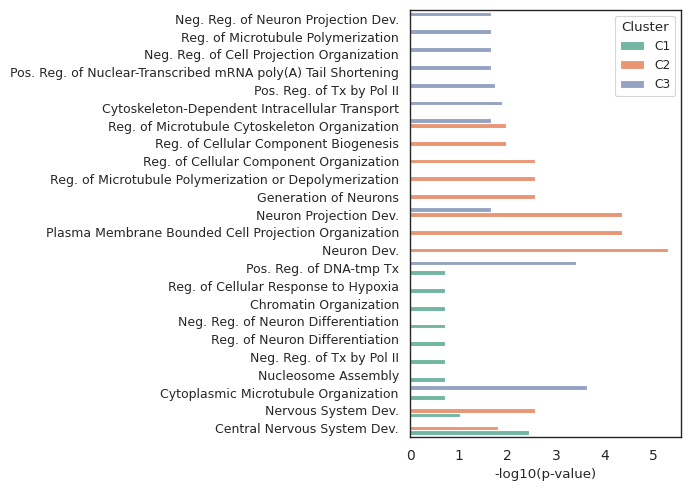

In [30]:
import seaborn as sns

cb_palette = sns.color_palette("Set2", 3)
enr_res['-log10(p-value)'] = -np.log10(enr_res['Adjusted P-value'])

df_plot = enr_res.copy()
df_plot['Short_term'] = df_plot['Term'].apply(shorten_term).str.replace(r"\s*\(GO:\d+\)", "", regex=True)
df_plot = df_plot.sort_values(by='-log10(p-value)', ascending=False)
mdf = pd.DataFrame()
for idx, (c,df) in enumerate(df_plot.groupby('Cluster')):
    sel_df = df.head(10).copy()
    if idx == 0:
        mdf = sel_df
    else:
        mdf = pd.concat([mdf, sel_df])

df_plot =mdf.copy()
# plot
plt.figure(figsize=(7,5))
sns.barplot(data=df_plot.head(30),
            x='-log10(p-value)',
            y='Short_term',
            palette={"C1":cb_palette[0],"C2":cb_palette[1],"C3":cb_palette[2]},
            hue='Cluster'
            )

plt.xlabel('-log10(p-value)')
plt.ylabel('')

plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()